#Predicting the Popularity of a Song on Spotify

Here is where we import the df that contains over 200 thousand songs on Spotify. At the bottom certain genres that we felt weren't very descriptive were removed. 

In [93]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/SpotifyFeatures.csv', index_col=3)
df = df.reset_index()

fulldf = df

df = df[df["genre"]!= "Movie"]
df = df[df["genre"] != "Soundtrack"]
df = df[df["genre"] != "Comedy"]
df = df.drop("artist_name", axis= 1)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##A Little Context about this Spotify Dataset

Genre Distribution

In [94]:
target = list(df["genre"])
counterDictionary = Counter(target)
print("Discribution of songs in terms of genre:")
counterDictionary.most_common()

Discribution of songs in terms of genre:


[('Indie', 9543),
 ('Jazz', 9441),
 ('Pop', 9386),
 ('Electronic', 9377),
 ('Children’s Music', 9353),
 ('Folk', 9299),
 ('Hip-Hop', 9295),
 ('Rock', 9272),
 ('Alternative', 9263),
 ('Classical', 9256),
 ('Rap', 9232),
 ('World', 9096),
 ('Soul', 9089),
 ('Blues', 9023),
 ('R&B', 8992),
 ('Anime', 8936),
 ('Reggaeton', 8927),
 ('Ska', 8874),
 ('Reggae', 8771),
 ('Dance', 8701),
 ('Country', 8664),
 ('Opera', 8280),
 ("Children's Music", 5403),
 ('A Capella', 119)]

Popularity Metrics (each song is assigned a popularity score between 0 and 100)

In [95]:
from collections import Counter
from collections import OrderedDict
import statistics

target = list(df["popularity"])
target.sort()
counterDictionary = Counter(target)
mostCommonScoresArray = counterDictionary.most_common()

print("Median popularity score:", statistics.median(target))
print("Average popularity score:", statistics.mean(target))
print("Top 10 most common popularity scores with their frequency:") 
mostCommonScoresArray[0:10]


Median popularity score: 46.0
Average popularity score: 43.49498521343243
Top 10 most common popularity scores with their frequency:


[(53, 5355),
 (50, 5324),
 (51, 5321),
 (52, 5275),
 (49, 5156),
 (54, 4964),
 (48, 4922),
 (47, 4793),
 (55, 4668),
 (56, 4590)]

looking at the graph below showing the distribution of popularity scores, it's immediately apparent that if follows a Gaussian distribution. The only exception is that there is a very large number of songs with a popularity score of 0

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 <a list of 8 Text major ticklabel objects>)

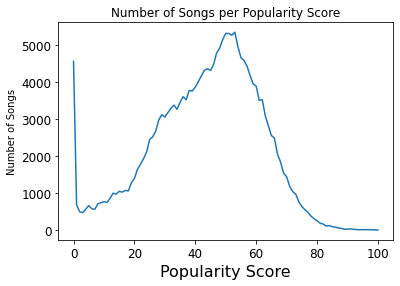

In [96]:
from matplotlib import pyplot as plt
plt.plot(list(counterDictionary.keys()), list(counterDictionary.values()))
plt.title("Number of Songs per Popularity Score")
plt.xlabel("Popularity Score", fontsize = 16)
plt.ylabel("Number of Songs")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

##Creating a Neural Network to Predict the Popularity of a Song

These two functions are for turning labels that are string into one-hot encodings. 

For Exmaple, if I had thre genres, rap, pop, and jazz, I would have to convert these values into something that the network can better interpret. The solution to this is one-hot encoding which turns the single column of Genre into three coloumns: is_Rap, is_Pop, and is_Jazz. Each song is then assigned a 1 or 0 for each column depending on what it is. 

In [97]:
#Function used for One-hot encoding of features
def encode_labels(orig_list, label_list):
    # print(len(label_list))
    y_coded = []
    for value in orig_list:
        y_coded.append(label_list.index(value))
    return y_coded

def add_encodings(encodings, categories):
    len(categories)
    #print(type(encodings))
    for i in range(len(categories[0])):
        # print("i = ", i)
        columns = []
        for array in encodings:
            columns.append(array[i])
        df[categories[0][i]] = columns

This code just uses the helper functions above, and applies it to all the categories that recquire one-hot encoding.

In [98]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
genre_enc= OneHotEncoder(handle_unknown='ignore')
key_enc = OneHotEncoder(handle_unknown='ignore')
tsig_enc = OneHotEncoder(handle_unknown='ignore')
mode_enc = OneHotEncoder(handle_unknown='ignore')

genres_list = np.array(df["genre"]).reshape(-1,1)
keys_list = np.array(df["key"]).reshape(-1,1)
tsigs_list = np.array(df["time_signature"]).reshape(-1,1)
modes_list = np.array(df["mode"]).reshape(-1,1)


genre_enc.fit(genres_list)
genre_categories = genre_enc.categories_
genres_encoded = genre_enc.transform(genres_list).toarray()


key_enc.fit(keys_list)
key_categories = key_enc.categories_
keys_encoded = key_enc.transform(keys_list).toarray()


tsig_enc.fit(tsigs_list)
tsig_categories = tsig_enc.categories_
tsigs_encoded = tsig_enc.transform(tsigs_list).toarray()


mode_enc.fit(modes_list)
mode_categories = mode_enc.categories_
modes_encoded = mode_enc.transform(modes_list).toarray()


Once we have the one-hot encodings, we no longer need to the original columns

In [99]:
df = df.drop("genre", axis = 1)
df = df.drop("key", axis = 1)
df = df.drop("time_signature", axis = 1)
df = df.drop("mode", axis = 1)

But we do need the new columns added!

In [100]:
add_encodings(genres_encoded, genre_categories)
add_encodings(keys_encoded, key_categories)
add_encodings(tsigs_encoded, tsig_categories)
add_encodings(modes_encoded, mode_categories)

In this next cell we are preparing the data form the dataframe to be used by the neural network. 

In [101]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

#choose all columns that are descriptive of the music and could be helful to the neural network. 
X_data = df[['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'A Capella', 'Alternative', 'Anime',
       'Blues', "Children's Music", 'Children’s Music', 'Classical', 'Country',
       'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Opera',
       'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul',
       'World', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G',
       'G#', '0/4', '1/4', '3/4', '4/4', '5/4', 'Major', 'Minor']].values

#assign all the actual popularity values to Y_data
Y_data = df['popularity'].values

#this normalizes the values describing the charactersits of each song which makes it easier for the network. 
X_data = (X_data - np.min(X_data, axis=0)) / (np.max(X_data, axis=0) - np.min(X_data, axis=0))

#here we split the data so that we have training data, validation data, and testing data 
X_train, X_other, Y_train, Y_other = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 3)
X_val, X_test, Y_val, Y_test = train_test_split(X_other, Y_other, test_size = 0.05, random_state = 3)

And here is the function that creates our model, which is a pretty vanilla sequential predictor model 

In [102]:
def buildModel():
  model = keras.Sequential()
  #our first layer has 256 nodes -- the input is expecting 53 value becuase that is how many we have 
  #from X_data above
  model.add(keras.layers.Dense(256, input_shape=(53,), activation='relu')),
  #between each layer we normalize the data
  model.add(tf.keras.layers.BatchNormalization()),
  #The second layer is 50 nodes
  model.add(keras.layers.Dense(units=50, activation='relu')),
  model.add(tf.keras.layers.BatchNormalization()),
  #there is only one node at the output layer becuase the model only has to output one number -- the projected
  #popularity of a song 
  model.add(keras.layers.Dense(units=1, activation='relu'))

  return model

Below is the code for training our model on the datafram with all songs of the allowed genres (remember that we filtered some out at the beginning)

In [103]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model1 = buildModel()

#our loss function is mean squared error hear for determining how large the cost was for each wrong answer
model1.compile(loss='MSE', optimizer=Adam(), metrics=['accuracy'])

model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)





Epoch 1/10
5140/5140 [==============================] - 16s 3ms/step - loss: 227.5638 - accuracy: 0.0132 - val_loss: 90.0623 - val_accuracy: 0.0153
Epoch 2/10
5140/5140 [==============================] - 15s 3ms/step - loss: 97.8461 - accuracy: 0.0096 - val_loss: 89.6259 - val_accuracy: 0.0153
Epoch 3/10
5140/5140 [==============================] - 15s 3ms/step - loss: 96.8930 - accuracy: 0.0097 - val_loss: 88.2541 - val_accuracy: 0.0154
Epoch 4/10
5140/5140 [==============================] - 15s 3ms/step - loss: 96.8444 - accuracy: 0.0102 - val_loss: 88.3811 - val_accuracy: 0.0155
Epoch 5/10
5140/5140 [==============================] - 14s 3ms/step - loss: 96.5647 - accuracy: 0.0082 - val_loss: 88.1898 - val_accuracy: 0.0146
Epoch 6/10
5140/5140 [==============================] - 14s 3ms/step - loss: 95.6041 - accuracy: 0.0082 - val_loss: 87.7341 - val_accuracy: 0.0154
Epoch 7/10
5140/5140 [==============================] - 14s 3ms/step - loss: 96.0497 - accuracy: 0.0099 - val_loss: 8

Below we can see that the model is actually able to do pretty well predicting the popularity of a song. Points that fall on the line represent a perfect guess, so it is very good knews to see the points follow the line. 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 <a list of 11 Text major ticklabel objects>)

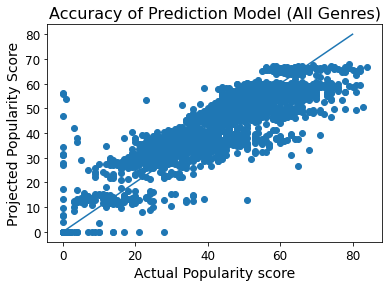

In [106]:
import matplotlib.pyplot as plt

plt.scatter(Y_test, model1.predict(X_test))
#This line represents x=y which makes sense as that would mean that x (the projected popularity score)
#is equal to y (the actual popularity score). 
plt.plot([0,80], [0,80])
plt.title("Accuracy of Prediction Model (All Genres)", fontsize = 16)
plt.xlabel("Actual Popularity score", fontsize = 14)
plt.ylabel("Projected Popularity Score", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


Here we do the exact same thing except to just for jazz music to see if the network can do better when it can specialize. 

In [107]:
df_jazz = df[df["Jazz"] == 1.0]

X_data = df_jazz[['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'A Capella', 'Alternative', 'Anime',
       'Blues', "Children's Music", 'Children’s Music', 'Classical', 'Country',
       'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Opera',
       'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul',
       'World', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G',
       'G#', '0/4', '1/4', '3/4', '4/4', '5/4', 'Major', 'Minor']].values

Y_data = df_jazz['popularity'].values

X_data = (X_data - np.min(X_data, axis=0)) / ((np.max(X_data, axis=0) - np.min(X_data, axis=0)) + 0.00000000000000000001)
X_train, X_other, Y_train, Y_other = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 3)
X_val, X_test, Y_val, Y_test = train_test_split(X_other, Y_other, test_size = 0.2, random_state = 3)

In [108]:
model2 = buildModel()

model2.compile(loss='MSE', optimizer=Adam(), metrics=['accuracy'])

model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Epoch 1/10
236/236 [==============================] - 2s 6ms/step - loss: 1264.1624 - accuracy: 0.0040 - val_loss: 1159.9989 - val_accuracy: 0.0060
Epoch 2/10
236/236 [==============================] - 1s 3ms/step - loss: 1004.9413 - accuracy: 0.0041 - val_loss: 614.3463 - val_accuracy: 0.0026
Epoch 3/10
236/236 [==============================] - 1s 3ms/step - loss: 529.6083 - accuracy: 0.0032 - val_loss: 298.6670 - val_accuracy: 0.0020
Epoch 4/10
236/236 [==============================] - 1s 4ms/step - loss: 236.6146 - accuracy: 0.0029 - val_loss: 166.1234 - val_accuracy: 0.0020
Epoch 5/10
236/236 [==============================] - 1s 5ms/step - loss: 120.9669 - accuracy: 0.0024 - val_loss: 112.8510 - val_accuracy: 0.0013
Epoch 6/10
236/236 [==============================] - 2s 9ms/step - loss: 85.5771 - accuracy: 0.0023 - val_loss: 96.2047 - val_accuracy: 0.0013
Epoch 7/10
236/236 [==============================] - 2s 7ms/step - loss: 84.8167 - accuracy: 0.0023 - val_loss: 93.1982 - 

Here we can see that the model does okay predicting the popularity based on only having one genre for data. The densest data is, in fact, clustered around the line. It does not appear fantastically better than the regular model though. The training loss is lower, but the validation loss is actually higher. 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 <a list of 11 Text major ticklabel objects>)

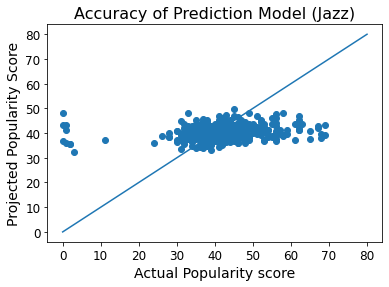

In [109]:
plt.scatter(Y_test, model2.predict(X_test))
plt.plot([0,80], [0,80])
plt.title("Accuracy of Prediction Model (Jazz)", fontsize = 16)
plt.xlabel("Actual Popularity score", fontsize = 14)
plt.ylabel("Projected Popularity Score", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

One could argue that jazz is too diverse to be a good choice for specialization. So here is the same code with pop music, which is widely regarded as much more predictable in terms of composition. 

In [110]:
df_pop = df[df["Pop"] == 1.0]

X_data = df_pop[['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'A Capella', 'Alternative', 'Anime',
       'Blues', "Children's Music", 'Children’s Music', 'Classical', 'Country',
       'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Opera',
       'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul',
       'World', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G',
       'G#', '0/4', '1/4', '3/4', '4/4', '5/4', 'Major', 'Minor']].values

Y_data = df_pop['popularity'].values

X_data = (X_data - np.min(X_data, axis=0)) / ((np.max(X_data, axis=0) - np.min(X_data, axis=0)) + 0.00000000000000000001)
X_train, X_other, Y_train, Y_other = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 3)
X_val, X_test, Y_val, Y_test = train_test_split(X_other, Y_other, test_size = 0.2, random_state = 3)

In [111]:
model3 = buildModel()

model3.compile(loss='MSE', optimizer=Adam(), metrics=['accuracy'])

model3.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Epoch 1/10
235/235 [==============================] - 2s 3ms/step - loss: 3563.0757 - accuracy: 0.0000e+00 - val_loss: 3369.4250 - val_accuracy: 0.0000e+00
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 2604.9668 - accuracy: 0.0000e+00 - val_loss: 2458.3354 - val_accuracy: 0.0000e+00
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 1984.7074 - accuracy: 0.0000e+00 - val_loss: 1453.2830 - val_accuracy: 0.0000e+00
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 1031.3495 - accuracy: 0.0000e+00 - val_loss: 1151.7096 - val_accuracy: 0.0000e+00
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 851.7111 - accuracy: 0.0000e+00 - val_loss: 1089.8772 - val_accuracy: 0.0000e+00
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 475.6004 - accuracy: 0.0000e+00 - val_loss: 607.3564 - val_accuracy: 0.0000e+00
Epoch 7/10
235/235 [==============================] - 1s 3ms/step -

The first graph below shows that the modeal once again does okay, but not fantastically better than how the unspecialized model. The loss is also higher here. 

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

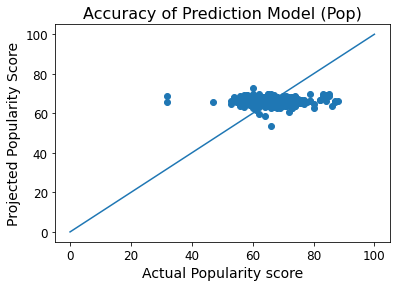

In [112]:
plt.scatter(Y_test, model3.predict(X_test))
plt.plot([0,100], [0,100])
plt.title("Accuracy of Prediction Model (Pop)", fontsize = 16)
plt.xlabel("Actual Popularity score", fontsize = 14)
plt.ylabel("Projected Popularity Score", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

However, when you compare it to how the orignal model plots the pop music, we see that it actually does perform a good deal better. This must mean that while the unspecialized model's loss is lower in general, it was actually struggling a bit with pop music. 

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

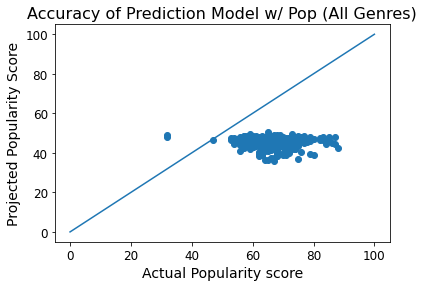

In [114]:
plt.scatter(Y_test, model1.predict(X_test))
plt.plot([0,100], [0,100])
plt.title("Accuracy of Prediction Model w/ Pop (All Genres)", fontsize = 16)
plt.xlabel("Actual Popularity score", fontsize = 14)
plt.ylabel("Projected Popularity Score", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#Music Trends

Here we are using creating a graph showing the popularity of certain genres of music over the decades. While this would be an easy problem if the oringal database included the data the song was released, it does not. 

To get the data, I am using the site AllMusic and am using Selenium to locate elements within the HTML that contain the release date for each song. 

In [79]:
#install necessary packages
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 968 kB 21.3 MB/s 
     |████████████████████████████████| 138 kB 56.3 MB/s 
     |████████████████████████████████| 359 kB 55.1 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 4.0 MB 55.3 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

In [80]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import sys
import os
import re
import random

#this is the code for getting a webdriver that can open up all of these AllMusic pages
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


#Here I have an array of all the genres in the dataset
genres = set(fulldf['genre'].values)
#and here I reduce down all the songs to these four elements
songs = fulldf[['track_name', 'artist_name', 'genre', 'popularity']].values

songDictionary = {}

for genre in genres: 
  #return only songs that are of this genre
  genreSpecificSongs = [(song[0], song[1], song[2], song[3]) for song in songs if song[2] == genre]
  #check how many songs there are in this section before you take a sample that is larger than the initial set 
  length = len(genreSpecificSongs)
  sampleSize = 0
  if length > 250:
    sampleSize = 250
  else:
    sampleSize = length
  genreSpecificSongs = random.sample(genreSpecificSongs, sampleSize) 
  iterations = 0
  completions = 0

  #becuase not all the songs can be found on All Music, I sample more than 100 songs, but only pull songs until I reach a hundred that can have a data appended, or run out of songs 
  while(completions <= 99):
    try:
      song = genreSpecificSongs[iterations]
    except:
      break
    songArray = song[0].split(" ")
    songUrl = "%20".join(songArray)
    songUrl = re.sub(r'\([^)]*\)', '', songUrl)
    #url for allmusic page where all songs of that name are shown
    url = "https://www.allmusic.com/search/all/" + songUrl
    wd.get(url)
    try:
      #use selenium to get each song returned from the search
      searchResults = wd.find_element(by=By.CLASS_NAME, value='search-results')
      returnedSongs = searchResults.find_elements(by=By.CLASS_NAME, value='song')
      #for reach song returned from search, get the title, and artists and check if this returned song is the one we are looking for 
      #if it is, then get the url for the specific song, go to the page, pull the date, create a new song object with the data
      # and add it to a dicitonary with all the completed songs of that genre 
      for returnedSong in returnedSongs:
        try:
          songTitle = returnedSong.find_element(by=By.CLASS_NAME, value='title')
          artists = returnedSong.find_element(by=By.CLASS_NAME, value='performers')
          songUrl = returnedSong.find_element(by=By.PARTIAL_LINK_TEXT, value=songTitle.text).get_attribute("href")
          if song[1] in artists.text:
            wd.get(songUrl)
            year = wd.find_element(by=By.CLASS_NAME, value='year')
            fullSong = (song[0], song[1], song[2], song[3], year.text.split("\n")[1])
            genreSongArray = songDictionary.get(genre)
            if genreSongArray == None:
              songDictionary[genre] = [fullSong]
            else:
              currentArray = songDictionary[genre]
              currentArray.append(fullSong)
              songDictionary[genre] = currentArray
            iterations += 1
            completions += 1
            print(completions)
            break
        except Exception as e: 
          continue
      iterations += 1
    except Exception as e:
      iterations += 1
      continue
  print(songDictionary[genre])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: use options instead of chrome_options
  del sys.path[0]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
[('Oliver James', 'Fleet Foxes', 'Indie', 47, '2008'), ('Take This Heart of Gold', 'Mandolin Orange', 'Indie', 55, '2016'), ('Shuggie', 'Foxygen', 'Indie', 64, '2013'), ('Stompa', 'Serena Ryder', 'Indie', 48, '2012'), ('Good Thing Go', 'Quinn XCII', 'Indie', 64, '2019'), ('Sail Away', 'Møme', 'Indie', 64, '2000'), ('You Shadow', 'Sharon Van Etten', 'Indie', 58, '2019'), ('We Are Fine', 'Sharon Van Etten', 'Indie', 53, '2012'), ('No Shade in the Shadow of The Cross', 'Sufjan Stevens', 'Indie', 52, '2015'), ('I Went To The Store One Day', 'Father John Misty', 'Indie', 44, '2015'), ('OctaHate', 'Ryn Weaver', 'Indie', 52, '2014'), ('Stupid Fish', 'Cherry Glazerr', 'Indie', 44, '2019'), ('Changing of the Seasons', 'Two Door Cinema Club', 'Indi

KeyboardInterrupt: ignored

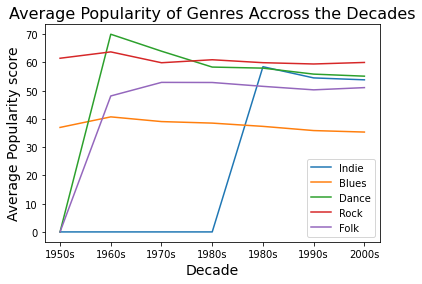

In [115]:
import matplotlib.pyplot as plt

data = {}
for genre in songDictionary.keys():
  songArray = songDictionary[genre]
  nineteenFifties = []
  nineteenSixties = []
  nineteenSeventies = []
  nineteenEighties = []
  nineteenNineties = []
  twoThousands = []
  twoThousandTens = []
  for song in songArray:
    year = int(song[4])
    if 1960 - year > 0:
      nineteenFifties.append(song[3])
    if 1970 - year > 0:
      nineteenSixties.append(song[3])
    if 1980 - year > 0:
      nineteenSeventies.append(song[3])
    if 1990 - year > 0:
      nineteenEighties.append(song[3])
    if 2000 - year > 0:
      nineteenNineties.append(song[3])
    if 2010 - year > 0:
      twoThousands.append(song[3])
    if 2020 - year > 0:
      twoThousandTens.append(song[3])
  fiftiesMean = 0
  sixtiesMean = 0
  seventiesMean = 0
  eightiesMean = 0
  ninetiesMean = 0 
  twoThousandsMean = 0
  twoThousandTensMean = 0 

  if len(nineteenFifties) > 0:
    fiftiesMean = statistics.mean(nineteenFifties)
  if len(nineteenSixties) > 0:
    sixtiesMean = statistics.mean(nineteenSixties)
  if len(nineteenSeventies) > 0:
    seventiesMean = statistics.mean(nineteenSeventies)
  if len(nineteenEighties) > 0:
    eightiesMean = statistics.mean(nineteenEighties)
  if len(nineteenNineties) > 0:
    ninetiesMean = statistics.mean(nineteenNineties)
  if len(twoThousands) > 0:
    twoThousandsMean = statistics.mean(twoThousands)
  if len(twoThousandTens) > 0:
    twoThousandTensMean = statistics.mean(twoThousandTens)



  data[genre] = np.array([fiftiesMean, sixtiesMean, seventiesMean, eightiesMean, ninetiesMean, twoThousandsMean, twoThousandTensMean])


Indie_y = data['Indie']
Blues_y = data['Blues']
A_Capella_y = data['A Capella']
Reggaeton_y = data['Reggaeton']
Folk_y = data['Folk']
Movie_y = data['Movie']
Dance_y = data['Dance']
Soul_y = data['Soul']
Rock_y = data['Rock']
Childrens_Music_Y = data["Children's Music"]
Anime_y = data["Anime"]









x = np.array([0,1,2,3,4,5,6])
my_xticks = ['1950s','1960s','1970s','1980s', '1980s', '1990s', '2000s', '2010s']
plt.xticks(x, my_xticks)
plt.plot(x, Indie_y, label='Indie')
plt.plot(x, Blues_y, label='Blues')
plt.plot(x, Dance_y, label='Dance')
plt.plot(x, Rock_y, label='Rock')
plt.plot(x, Folk_y, label='Folk')
# plt.plot(x, Indie_y, label='R&B')
# plt.plot(x, Indie_y, label='R&B')
# plt.plot(x, Indie_y, label='R&B')
# plt.plot(x, Indie_y, label='R&B')
# plt.plot(x, Indie_y, label='R&B')
# plt.plot(x, Indie_y, label='R&B')
plt.legend(loc='best')
plt.title("Average Popularity of Genres Accross the Decades", fontsize = 16)
plt.ylabel("Average Popularity score", fontsize = 14)
plt.xlabel("Decade", fontsize = 14)
plt.show()